# Agent Simulation: Persona-Based Behavioral Testing

**Objective**: Instantiate Claude-powered agents from persona profiles and test their responses to product scenarios.

## Workflow
1. Setup — Import agents module, load personas
2. Define Scenarios — Product offers designed to probe persona differences
3. Run Simulations — Execute scenarios across all 7 personas
4. Analyze Responses — Compare decisions and reasoning
5. Validate Differentiation — Verify personas respond consistently with their profiles

## 1. Environment Setup

In [6]:
%pip install python-dotenv
%pip install anthropic

You should consider upgrading via the '/Users/emilyhk/practice/blok-persona-clustering/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/emilyhk/practice/blok-persona-clustering/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import sys
from pathlib import Path
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Add src to path for imports
sys.path.insert(0, str(Path.cwd().parent / 'src'))

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display

from agents import PersonaSimulator, PersonaAgent

# Style settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
pd.set_option('display.max_colwidth', 200)

# Output directory
OUTPUT_DIR = Path('./outputs/05_agent_simulation')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Output directory: {OUTPUT_DIR.resolve()}")

Output directory: /Users/emilyhk/practice/blok-persona-clustering/notebooks/outputs/05_agent_simulation


## 2. Initialize Simulator

Set `mock_mode=True` to test without API access. Switch to `False` when you have an API key configured.

In [5]:
# Initialize simulator
# Set mock_mode=False when ANTHROPIC_API_KEY is configured
simulator = PersonaSimulator(
    personas_path='../data/processed/personas.json',
    mock_mode=False  # Change to False for real API calls
)

# Load personas and initialize agents
simulator.load_personas()
simulator.initialize_agents()

# Display persona summary
print("Loaded personas:")
simulator.get_persona_summary()

Loaded personas:


,cluster_id,persona_name,size,percentage
0,0,Mainstream Shopper,27686,29.7%
1,1,Weekend Buyer,10738,11.5%
2,2,Cash Customer,15314,16.4%
3,3,High-Value Financing Shopper,15022,16.1%
4,4,Bulk Buyer,7619,8.2%
5,5,Loyal Explorer Customer,2781,3.0%
6,6,Critical Shopper,14197,15.2%


In [6]:
# Quick test: Single agent response
test_agent = simulator.agents[0]  # Mainstream Shopper
print(f"Testing: {test_agent.persona_name}")
print("-" * 50)
response = test_agent.respond_with_decision("Would you buy a R$150 headphone with free shipping?")
print(response)

Testing: Mainstream Shopper
--------------------------------------------------
{'persona_name': 'Mainstream Shopper', 'cluster_id': 0, 'decision': 'Maybe', 'raw_response': "DECISION: Maybe\n\nREASONING: R$150 is more than double what I typically spend on a single item, so I'd need to really think this through. The free shipping helps, but I'd want to make sure these headphones are something I genuinely need and will use regularly. I'd probably look for a way to pay in installments since that fits better with how I usually manage my purchases.\n\nKEY FACTORS:\n• Price is significantly higher than my usual R$71 average - need strong justification\n• Free shipping removes additional costs, which is good for my budget\n• Would definitely want to pay via credit card with installment options (2-3 payments)\n• Need to evaluate if this is a necessary purchase or just a want\n• Would research reviews to ensure satisfaction since this is a bigger investment for me"}


In [7]:
# Initialize simulator
# Set mock_mode=False when ANTHROPIC_API_KEY is configured
simulator = PersonaSimulator(
    personas_path='../data/processed/personas.json',
    mock_mode=False  # Change to False for real API calls
)

# Load personas and initialize agents
simulator.load_personas()
simulator.initialize_agents()

# Display persona summary
print("Loaded personas:")
simulator.get_persona_summary()

Loaded personas:


,cluster_id,persona_name,size,percentage
0,0,Mainstream Shopper,27686,29.7%
1,1,Weekend Buyer,10738,11.5%
2,2,Cash Customer,15314,16.4%
3,3,High-Value Financing Shopper,15022,16.1%
4,4,Bulk Buyer,7619,8.2%
5,5,Loyal Explorer Customer,2781,3.0%
6,6,Critical Shopper,14197,15.2%


## 3. Define Test Scenarios

Each scenario is designed to probe specific persona differences:

| Scenario | Tests | Expected Differentiation |
|----------|-------|--------------------------|
| Financing offer | Installment preference | High-Value Financing vs Cash Customer |
| Flash sale | Urgency, price sensitivity | Budget vs Premium personas |
| Bundle deal | Basket behavior | Bulk Buyer vs single-item personas |
| New category | Exploration tendency | Loyal Explorer vs Focused personas |
| Mixed reviews | Risk tolerance | Critical Shopper vs Satisfied personas |
| Weekend promotion | Shopping timing | Weekend Buyer vs Weekday shoppers |

In [9]:
SCENARIOS = [
    {
        "name": "financing_offer",
        "text": """You're looking at a smartphone priced at R$1,200. 
The seller offers 10x installments of R$120 with no interest on credit card.
Alternatively, you can pay R$1,080 upfront via boleto (10% discount).
The phone has good reviews (4.2 stars) and ships in 3 days.
Would you buy this phone? Which payment option would you choose?"""
    },
    {
        "name": "flash_sale",
        "text": """FLASH SALE: A kitchen blender you've been eyeing is now 40% off!
Original price: R$250 → Sale price: R$150
The catch: Sale ends in 2 hours. You weren't planning to buy today.
Reviews are positive (4.5 stars), and you've needed a blender for a while.
Do you buy it now, or wait and risk missing the deal?"""
    },
    {
        "name": "bundle_deal",
        "text": """You need to buy replacement ink cartridges for your printer.
Single cartridge: R$45 each
Bundle of 3: R$115 (save 15%)
You definitely need 1 now, might need the others in 3-6 months.
Would you buy the single cartridge or the bundle?"""
    },
    {
        "name": "new_category",
        "text": """You've never bought fitness equipment online before, but you see an ad:
Adjustable dumbbells set for R$280 with 4.3 star reviews.
You've been thinking about working out at home.
This marketplace has always worked well for your electronics purchases.
Would you try buying fitness equipment from this platform?"""
    },
    {
        "name": "mixed_reviews",
        "text": """You found the exact wireless earbuds you want at R$180.
However, the reviews are mixed: 3.5 stars overall.
Positive reviews praise sound quality. Negative reviews mention Bluetooth connectivity issues.
The seller has a 30-day return policy.
Would you take the risk on these earbuds?"""
    },
    {
        "name": "weekend_promo",
        "text": """It's Tuesday, and you see a promotion:
'WEEKEND SPECIAL: 20% off all home decor items, Saturday-Sunday only!'
There's a decorative lamp you like for R$120 (would be R$96 with discount).
You could buy now at full price and get it by Thursday,
or wait for the weekend, buy at discount, and receive it next week.
What would you do?"""
    }
]

print(f"Defined {len(SCENARIOS)} test scenarios:")
for s in SCENARIOS:
    print(f"  - {s['name']}")

Defined 6 test scenarios:
  - financing_offer
  - flash_sale
  - bundle_deal
  - new_category
  - mixed_reviews
  - weekend_promo


## 4. Run Simulations

In [10]:
# Run all scenarios across all personas
print("Running simulations...")
print(f"  {len(SCENARIOS)} scenarios × {len(simulator.agents)} personas = {len(SCENARIOS) * len(simulator.agents)} total calls")
print()

results = simulator.run_batch(SCENARIOS, structured=True)

print(f"Completed! {len(results)} responses collected.")
results.head(10)

Running simulations...
  6 scenarios × 7 personas = 42 total calls

Completed! 42 responses collected.


,cluster_id,persona_name,decision,response,scenario_name
0,0,Mainstream Shopper,No,"DECISION: No\n\nREASONING: This smartphone is way outside my typical spending range - at R$1,200, it's nearly 17 times what I normally spend per purchase. Even with the installment option breaking...",financing_offer
1,1,Weekend Buyer,No,"DECISION: No\n\nREASONING: This smartphone is way beyond my typical spending range - at R$1,200, it's nearly 14 times what I usually spend per purchase (R$86). Even though the credit card installm...",financing_offer
2,2,Cash Customer,No,"DECISION: No\n\nREASONING: At R$1,080 with the boleto discount, this smartphone is still way beyond what I typically spend - that's nearly 12 times my usual purchase amount of R$89. Even though I ...",financing_offer
3,3,High-Value Financing Shopper,Yes,DECISION: Yes\n\nREASONING: This smartphone fits perfectly with my shopping approach - I can afford the R$120 monthly payments which makes this high-quality item accessible without straining my bu...,financing_offer
4,4,Bulk Buyer,Maybe,"DECISION: Maybe\n\nREASONING: At R$1,200, this phone is significantly higher than my typical purchase range, but the 10x installment option makes it more manageable at R$120 per month. I'd need to...",financing_offer
5,5,Loyal Explorer Customer,No,"DECISION: No\n\nREASONING: This smartphone is way outside my typical spending range - at R$1,200, it's nearly five times what I usually spend on a single item (around R$106). Even though the insta...",financing_offer
6,6,Critical Shopper,No,"DECISION: No\n\nREASONING: This smartphone is way beyond what I typically spend - at R$1,200, it's more than 13 times my usual purchase amount of R$89. Even with the 10% boleto discount bringing i...",financing_offer
7,0,Mainstream Shopper,Yes,"DECISION: Yes\n\nREASONING: At R$150, this blender fits well within my typical spending range, and I can easily put it on my credit card to spread the payment over a couple of months. Since I actu...",flash_sale
8,1,Weekend Buyer,Yes,"DECISION: Yes\n\nREASONING: At R$150, this blender fits well within my typical purchase range, and I can easily put it on my credit card to spread the payment over a few months. Since I actually n...",flash_sale
9,2,Cash Customer,No,"DECISION: No\n\nREASONING: Even with the 40% discount, R$150 is still a significant expense that I wasn't budgeted for today. I prefer to make planned purchases when I have the money set aside, ra...",flash_sale


In [11]:
# Save raw results
results.to_csv(OUTPUT_DIR / 'simulation_results.csv', index=False)
print(f"Saved: {OUTPUT_DIR / 'simulation_results.csv'}")

Saved: outputs/05_agent_simulation/simulation_results.csv


## 5. Analyze Responses

### 5.1 Decision Summary by Persona

In [12]:
# Pivot: decisions by persona and scenario
decision_pivot = results.pivot_table(
    index='persona_name',
    columns='scenario_name',
    values='decision',
    aggfunc='first'
)

print("Decision Matrix (Persona × Scenario):")
decision_pivot

Decision Matrix (Persona × Scenario):


scenario_name,bundle_deal,financing_offer,flash_sale,mixed_reviews,new_category,weekend_promo
persona_name,,,,,,
Bulk Buyer,Yes,Maybe,Yes,Yes,Yes,No
Cash Customer,Unclear,No,No,No,Maybe,Maybe
Critical Shopper,No,No,No,No,No,No
High-Value Financing Shopper,Yes,Yes,Maybe,Yes,Yes,Yes
Loyal Explorer Customer,Yes,No,Yes,Yes,Yes,Maybe
Mainstream Shopper,Yes,No,Yes,No,Maybe,Yes
Weekend Buyer,Yes,No,Yes,No,Maybe,Maybe


In [13]:
# Count decisions by persona
decision_counts = results.groupby(['persona_name', 'decision']).size().unstack(fill_value=0)
print("Decision counts by persona:")
decision_counts

Decision counts by persona:


decision,Maybe,No,Unclear,Yes
persona_name,,,,
Bulk Buyer,1,1,0,4
Cash Customer,2,3,1,0
Critical Shopper,0,6,0,0
High-Value Financing Shopper,1,0,0,5
Loyal Explorer Customer,1,1,0,4
Mainstream Shopper,1,2,0,3
Weekend Buyer,2,2,0,2


### 5.2 Response Deep Dive

Examine individual responses to verify persona consistency.

In [14]:
def display_scenario_responses(scenario_name: str, results_df: pd.DataFrame):
    """Display all persona responses for a given scenario."""
    scenario_results = results_df[results_df['scenario_name'] == scenario_name]
    
    display(Markdown(f"## Scenario: {scenario_name}"))
    display(Markdown("---"))
    
    for _, row in scenario_results.iterrows():
        decision_emoji = "✅" if row['decision'] == 'Yes' else "❌" if row['decision'] == 'No' else "🤔"
        display(Markdown(f"### {row['persona_name']} {decision_emoji}"))
        display(Markdown(f"**Decision**: {row['decision']}"))
        display(Markdown(f"\n{row['response'][:500]}{'...' if len(row['response']) > 500 else ''}"))
        display(Markdown("---"))

In [15]:
# Examine financing offer responses (tests installment preferences)
display_scenario_responses('financing_offer', results)

## Scenario: financing_offer

---

### Mainstream Shopper ❌

**Decision**: No


DECISION: No

REASONING: This smartphone is way outside my typical spending range - at R$1,200, it's nearly 17 times what I normally spend per purchase. Even with the installment option breaking it down to R$120 per month, that's still more than my entire usual purchase amount. While I appreciate credit card flexibility, this would be a major departure from my careful, modest spending habits.

KEY FACTORS:
• Price far exceeds my normal R$71 purchase range - this represents a significant financia...

---

### Weekend Buyer ❌

**Decision**: No


DECISION: No

REASONING: This smartphone is way beyond my typical spending range - at R$1,200, it's nearly 14 times what I usually spend per purchase (R$86). Even though the credit card installments would break it down to R$120 per month, that's still more than my entire average order value, and I prefer to keep my purchases simple and affordable. The 4.2-star rating is decent, but not exceptional enough to justify such a significant departure from my normal spending habits.

KEY FACTORS:
• Pric...

---

### Cash Customer ❌

**Decision**: No


DECISION: No

REASONING: At R$1,080 with the boleto discount, this smartphone is still way beyond what I typically spend - that's nearly 12 times my usual purchase amount of R$89. Even though I appreciate the upfront payment discount and would definitely choose boleto over installments, this purchase is simply too expensive for my budget and shopping patterns.

KEY FACTORS:
• Price point far exceeds my typical spending range (R$1,080 vs my usual R$89)
• While I prefer the boleto option due to my...

---

### High-Value Financing Shopper ✅

**Decision**: Yes


DECISION: Yes

REASONING: This smartphone fits perfectly with my shopping approach - I can afford the R$120 monthly payments which makes this high-quality item accessible without straining my budget. The 4.2-star rating gives me confidence in the product quality, and I appreciate having financing options that let me get what I need now while managing my cash flow.

KEY FACTORS:
• Monthly payment of R$120 is manageable within my budget constraints
• No-interest installments make the financing cos...

---

### Bulk Buyer 🤔

**Decision**: Maybe


DECISION: Maybe

REASONING: At R$1,200, this phone is significantly higher than my typical purchase range, but the 10x installment option makes it more manageable at R$120 per month. I'd need to think carefully about whether I really need this upgrade right now, especially since I tend to be practical about my purchases and focus on getting good value.

KEY FACTORS:
• Price point is much higher than my usual spending patterns (R$82 average item price)
• 10x installments align well with my credit...

---

### Loyal Explorer Customer ❌

**Decision**: No


DECISION: No

REASONING: This smartphone is way outside my typical spending range - at R$1,200, it's nearly five times what I usually spend on a single item (around R$106). Even though the installment option makes it more manageable at R$120 per month, that's still a significant commitment that would impact my ability to make my usual diverse purchases across different categories. While I appreciate good deals and the reviews are decent, this just doesn't fit my shopping pattern of moderate spen...

---

### Critical Shopper ❌

**Decision**: No


DECISION: No

REASONING: This smartphone is way beyond what I typically spend - at R$1,200, it's more than 13 times my usual purchase amount of R$89. Even with the 10% boleto discount bringing it to R$1,080, this represents a massive financial commitment that doesn't align with my shopping patterns. While the reviews seem decent at 4.2 stars, I need products that truly exceed expectations, and I'm skeptical about making such a large investment.

KEY FACTORS:
• Price far exceeds my typical spendi...

---

In [16]:
# Examine mixed reviews responses (tests risk tolerance)
display_scenario_responses('mixed_reviews', results)

## Scenario: mixed_reviews

---

### Mainstream Shopper ❌

**Decision**: No


DECISION: No

REASONING: At R$180, these earbuds are well above my typical spending range of around R$71 per purchase, and the mixed reviews with specific connectivity issues are a red flag. While I appreciate having a return policy as backup, I prefer purchases that work reliably from the start rather than dealing with potential problems and returns.

KEY FACTORS:
• Price point is significantly higher than my usual purchase range
• Mixed reviews (3.5 stars) indicate inconsistent quality, especi...

---

### Weekend Buyer ❌

**Decision**: No


DECISION: No

REASONING: At R$180, these earbuds are double my typical purchase amount, and the mixed reviews with connectivity issues are concerning. Since I typically buy single items and expect them to work reliably, spending this much on something with known technical problems doesn't align with my shopping approach. I'd rather find a more affordable option with better reviews that I can purchase confidently with my credit card.

KEY FACTORS:
• Price is significantly higher than my usual R$8...

---

### Cash Customer ❌

**Decision**: No


DECISION: No

REASONING: At R$180, these earbuds are a significant purchase for me, and I can't justify the risk with mixed reviews mentioning connectivity issues. I prefer to buy products I'm confident will work properly since I pay upfront with boleto and want to avoid the hassle of returns. I'd rather wait and save up for a more reliable option with better reviews.

KEY FACTORS:
• Mixed 3.5-star reviews create too much uncertainty for this price point
• Bluetooth connectivity issues could mak...

---

### High-Value Financing Shopper ✅

**Decision**: Yes


DECISION: Yes

REASONING: At R$180, I can spread this across 6-8 installments making it very manageable monthly. The positive reviews specifically mention good sound quality, which is what I care about most, and the 30-day return policy gives me protection if the Bluetooth issues are deal-breakers. I'd rather pay a bit more for the exact product I want than settle for something cheaper that might not meet my needs.

KEY FACTORS:
• Monthly payment of R$25-30 through installments makes this afford...

---

### Bulk Buyer ✅

**Decision**: Yes


DECISION: Yes

REASONING: At R$180, these earbuds fit within my budget for a quality purchase, and since I tend to buy multiple items when shopping, I can justify the expense as part of a larger order. The 30-day return policy provides adequate protection against the connectivity issues mentioned in reviews, and the positive feedback on sound quality suggests the core functionality is solid.

KEY FACTORS:
• 30-day return policy minimizes my risk if connectivity problems arise
• Sound quality pra...

---

### Loyal Explorer Customer ✅

**Decision**: Yes


DECISION: Yes

REASONING: At R$180, these earbuds are priced reasonably within my typical spending range, and the 30-day return policy gives me confidence to try them out. While the 3.5-star rating isn't ideal, the fact that positive reviews specifically mention good sound quality - which is what matters most to me in earbuds - makes it worth the risk. I'm comfortable making this purchase knowing I can return them if the Bluetooth issues prove problematic.

KEY FACTORS:
• 30-day return policy pr...

---

### Critical Shopper ❌

**Decision**: No


DECISION: No

REASONING: With mixed 3.5-star reviews and specific mentions of Bluetooth connectivity issues, these earbuds don't meet my standards for a R$180 purchase. I don't have tolerance for products that might not work properly, especially when connectivity problems could make them essentially useless. While the return policy offers some protection, I'd rather find a more reliable option than deal with potential hassles.

KEY FACTORS:
• Below-average review rating (3.5 stars) signals quali...

---

### 5.3 Visualize Decision Patterns

/var/folders/sk/33j57r6168b4mqs5v6nkhf1h0000gn/T/ipykernel_61356/2032860061.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  decision_numeric = decision_pivot.replace(decision_map)


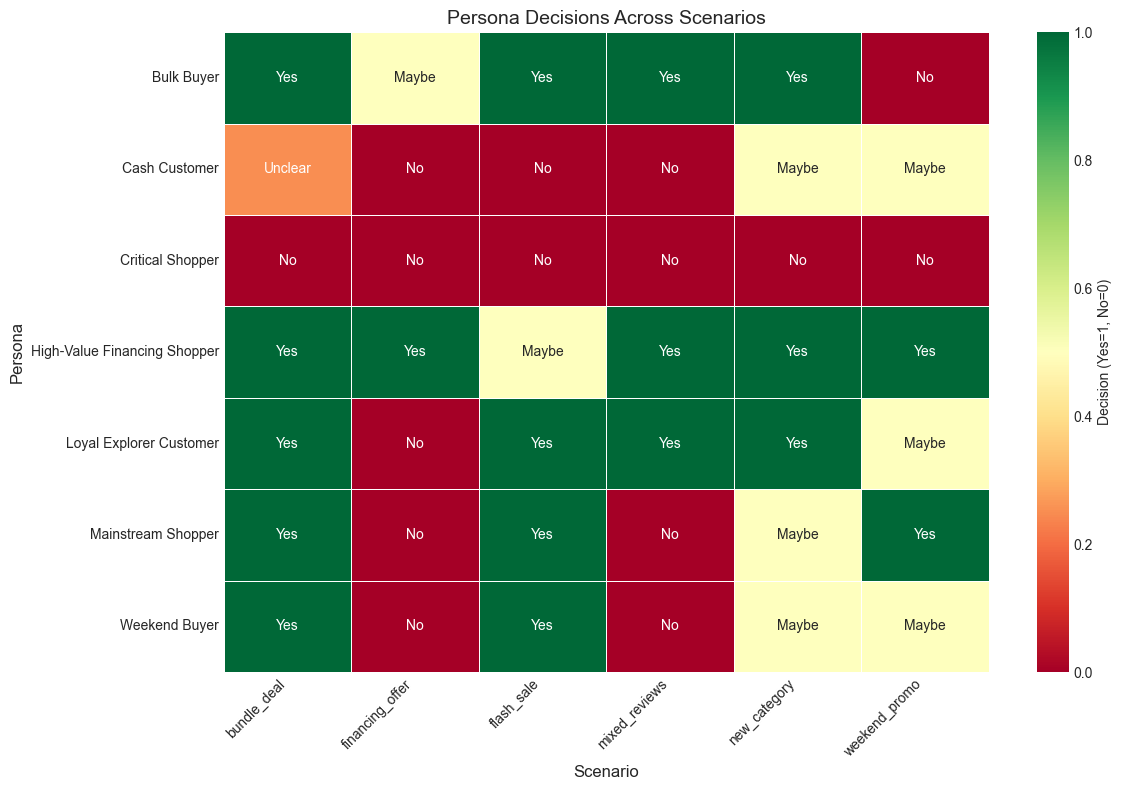

Saved: outputs/05_agent_simulation/decision_heatmap.png


In [17]:
# Create decision heatmap
# Map decisions to numeric for visualization
decision_map = {'Yes': 1, 'Maybe': 0.5, 'No': 0, 'Unclear': 0.25}
decision_numeric = decision_pivot.replace(decision_map)

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(
    decision_numeric,
    annot=decision_pivot.values,
    fmt='',
    cmap='RdYlGn',
    center=0.5,
    linewidths=0.5,
    ax=ax,
    cbar_kws={'label': 'Decision (Yes=1, No=0)'}
)
ax.set_title('Persona Decisions Across Scenarios', fontsize=14)
ax.set_xlabel('Scenario', fontsize=12)
ax.set_ylabel('Persona', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'decision_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {OUTPUT_DIR / 'decision_heatmap.png'}")

## 6. Validate Persona Differentiation

Check if personas respond consistently with their defining characteristics.

In [18]:
def validate_persona_consistency(results_df: pd.DataFrame) -> dict:
    """
    Validate that personas respond as expected based on their profiles.
    
    Returns dict with validation results for key persona-scenario pairs.
    """
    validations = []
    
    # Expected behaviors based on persona profiles
    expectations = [
        {
            "persona": "Cash Customer",
            "scenario": "financing_offer",
            "expected": "Should prefer boleto/upfront payment over installments",
            "check_keywords": ["boleto", "upfront", "discount", "cash", "pay now"]
        },
        {
            "persona": "High-Value Financing Shopper",
            "scenario": "financing_offer",
            "expected": "Should prefer installment option, focus on monthly cost",
            "check_keywords": ["installment", "monthly", "spread", "payment plan"]
        },
        {
            "persona": "Bulk Buyer",
            "scenario": "bundle_deal",
            "expected": "Should prefer the bundle over single item",
            "check_keywords": ["bundle", "three", "save", "stock up"]
        },
        {
            "persona": "Critical Shopper",
            "scenario": "mixed_reviews",
            "expected": "Should be hesitant due to negative reviews",
            "check_keywords": ["concern", "risk", "issue", "hesitant", "wait", "no"]
        },
        {
            "persona": "Loyal Explorer Customer",
            "scenario": "new_category",
            "expected": "Should be open to trying new category",
            "check_keywords": ["try", "open", "trust", "explore", "yes"]
        },
        {
            "persona": "Weekend Buyer",
            "scenario": "weekend_promo",
            "expected": "Should prefer waiting for weekend deal",
            "check_keywords": ["wait", "weekend", "discount", "saturday", "sunday"]
        }
    ]
    
    for exp in expectations:
        row = results_df[
            (results_df['persona_name'] == exp['persona']) & 
            (results_df['scenario_name'] == exp['scenario'])
        ]
        
        if row.empty:
            continue
            
        response = row.iloc[0]['response'].lower()
        decision = row.iloc[0]['decision']
        
        # Check if any expected keywords appear
        keywords_found = [kw for kw in exp['check_keywords'] if kw in response]
        
        validations.append({
            "persona": exp['persona'],
            "scenario": exp['scenario'],
            "expectation": exp['expected'],
            "decision": decision,
            "keywords_found": keywords_found,
            "aligned": len(keywords_found) > 0
        })
    
    return validations


# Run validation
validations = validate_persona_consistency(results)
validation_df = pd.DataFrame(validations)

print("Persona Consistency Validation:")
print("=" * 60)
for v in validations:
    status = "✅" if v['aligned'] else "❓"
    print(f"\n{status} {v['persona']} on {v['scenario']}")
    print(f"   Expected: {v['expectation']}")
    print(f"   Decision: {v['decision']}")
    print(f"   Keywords found: {v['keywords_found']}")

Persona Consistency Validation:

✅ Cash Customer on financing_offer
   Expected: Should prefer boleto/upfront payment over installments
   Decision: No
   Keywords found: ['boleto', 'upfront', 'discount', 'cash']

✅ High-Value Financing Shopper on financing_offer
   Expected: Should prefer installment option, focus on monthly cost
   Decision: Yes
   Keywords found: ['installment', 'monthly', 'spread']

✅ Bulk Buyer on bundle_deal
   Expected: Should prefer the bundle over single item
   Decision: Yes
   Keywords found: ['bundle', 'three']

✅ Critical Shopper on mixed_reviews
   Expected: Should be hesitant due to negative reviews
   Decision: No
   Keywords found: ['concern', 'issue', 'no']

✅ Loyal Explorer Customer on new_category
   Expected: Should be open to trying new category
   Decision: Yes
   Keywords found: ['trust', 'explore', 'yes']

✅ Weekend Buyer on weekend_promo
   Expected: Should prefer waiting for weekend deal
   Decision: Maybe
   Keywords found: ['weekend', 'disc

In [19]:
# Summary statistics
if len(validation_df) > 0:
    alignment_rate = validation_df['aligned'].mean() * 100
    print(f"\nOverall alignment rate: {alignment_rate:.0f}%")
    print(f"({validation_df['aligned'].sum()}/{len(validation_df)} expectations met)")


Overall alignment rate: 100%
(6/6 expectations met)


## 7. Summary

In [20]:
print("\n" + "="*60)
print("SIMULATION COMPLETE")
print("="*60)

print(f"\nSimulation Summary:")
print(f"  - Personas tested: {len(simulator.agents)}")
print(f"  - Scenarios run: {len(SCENARIOS)}")
print(f"  - Total responses: {len(results)}")
print(f"  - Mode: {'Mock' if simulator.mock_mode else 'Live API'}")

print(f"\nOutput files:")
print(f"  - simulation_results.csv")
print(f"  - decision_heatmap.png")

print(f"\nNext Steps:")
print(f"  1. Set ANTHROPIC_API_KEY and change mock_mode=False for real responses")
print(f"  2. Add more scenarios to probe specific persona behaviors")
print(f"  3. Refine persona prompts based on simulation results")


SIMULATION COMPLETE

Simulation Summary:
  - Personas tested: 7
  - Scenarios run: 6
  - Total responses: 42
  - Mode: Live API

Output files:
  - simulation_results.csv
  - decision_heatmap.png

Next Steps:
  1. Set ANTHROPIC_API_KEY and change mock_mode=False for real responses
  2. Add more scenarios to probe specific persona behaviors
  3. Refine persona prompts based on simulation results
